# Railway Data Extraction with Aggregation

Extract air temperature data and buckling probability along a linestring describing a railway line and aggregate to find the maximum values within a six hour window.

## Setup

Imports and data load.

In [1]:
import csv

import cartopy.crs as ccrs
import iris
import iris.coord_categorisation as iccat
import iris.plot as iplt
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString

import shapecutter

### Data load

Load datasets of air temperature and buckling probability, and data that describes a railway line.

In [2]:
rail_lat_lons = [
    [51.568877129691685, -0.10808509311982246],
    [51.59323320738075, -0.11951698431857623],
    [51.59526229129475, -0.12115011163268377],
    [51.611491699575915, -0.1440138940301914],
    [51.62467382277337, -0.15544578522894478],
    [51.65913204441527, -0.1766764403123449],
    [51.68343973090141, -0.1783095676264523],
    [51.712794116793525, -0.20280647733806748],
    [51.70672235780752, -0.1946408407675292],
    [51.7451630679815, -0.22403713242146747],
    [51.78862235202789, -0.2126052412227136],
    [51.8148797635516, -0.20117335002395992],
    [51.847175587261056, -0.17504331299823722],
    [51.895575907406595, -0.1946408407675292],
    [51.962041316188795, -0.27139782453058975],
    [52.00835918062153, -0.26721381208487727],
    [52.05457752210373, -0.26394755745666176],
    [52.11479053696101, -0.27048006671309244],
    [52.164906005387095, -0.2802788305977387],
    [52.20095423266889, -0.28354508522595373],
    [52.27196372822802, -0.22475249263307465],
    [52.3238986285102, -0.19698932829324434],
    [52.36181254751899, -0.18392430978038277],
    [52.395707974369024, -0.21332060143432116],
    [52.44569623911324, -0.2397950258037104],
    [52.60403350937584, -0.2825218114798374],
    [52.640582508609086, -0.3466119899940277],
    [52.69476027803933, -0.4476025743194185],
    [52.76297566892796, -0.5116927528336089],
    [52.853372656633695, -0.6126833371589998],
    [52.96230296715959, -0.6456994897269157],
    [53.02075447813583, -0.7117317961246676],
    [53.155048241128654, -0.8175617577729899],
    [53.19578987584783, -0.8195038843946318],
    [53.26670427751568, -0.9030153333842201],
    [53.36300580691406, -0.9845846514931895],
    [53.4174416813236, -1.019542930682748],
    [53.49607679374071, -1.0875173624402223],
    [53.6022003701201, -1.1182665601458466],
    [53.72130901754783, -1.0920478507536777],
    [53.7850402901577, -1.1648775990652578],
    [53.86986497443909, -1.1765303587951104],
    [53.96080291374333, -1.096903162181237],
    [54.037288725472244, -1.1842988729320627],
    [54.14834179514083, -1.2833473306358114],
    [54.251155961177744, -1.3959906813949996],
    [54.351688223521485, -1.4508493383411185],
    [54.46528556013235, -1.5576663025314361],
    [54.4709289534518, -1.555724175909794],
    [54.53239147327995, -1.54310035286912],
    [54.590385818639845, -1.5625216190855413],
    [54.64380265373373, -1.5032867538917896],
    [54.67918779018291, -1.5353318464614216],
    [54.736412683225375, -1.596508836305068],
    [54.7845984030466, -1.5809718222277518],
    [54.86738842437011, -1.588740332500077],
    [54.963948188152564, -1.6198143584463514],
    [55.02522414306342, -1.5800007778457146],
    [55.16247579518258, -1.6848756154143896],
    [55.235631783805815, -1.6149590543536962],
    [55.33517349630839, -1.6470041436107918],
    [55.404152902974374, -1.6402066931790102],
    [55.47356250690207, -1.6683675315589195],
    [55.541201815442406, -1.725660267055102],
    [55.59998337388424, -1.8001090693456672],
    [55.67014377607834, -1.878765197522173],
    [55.75712128396987, -1.9982059879868321],
    [55.84554082862181, -2.080746405055833],
    [55.858077947127555, -2.236116534787203],
    [55.99952080939376, -2.5167538507798843],
    [56.00657940492342, -2.7031980064575283],
    [55.96420848784529, -2.9246004754754122],
    [55.95224932060645, -3.1751348096672465],
]

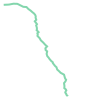

In [3]:
# Lon/lat values are transposed...
rail_line = LineString([(x, y) for [y, x] in rail_lat_lons])
rail_line

In [4]:
cube = iris.load_cube("agl_temperature.nc")
buckling_prob_cube = iris.load_cube("rail_temperature.nc", "rail_buckling_probability")

### Aggregate cubes on 6hr window

In [5]:
iccat.add_categorised_coord(cube, "6hr", "time", lambda coord, value: value // 6)
iccat.add_categorised_coord(buckling_prob_cube, "6hr", "time", lambda coord, value: value // 6)

In [6]:
max_agg_cube_6hr = cube.aggregated_by("6hr", iris.analysis.MAX)
max_agg_prob_cube = buckling_prob_cube.aggregated_by("6hr", iris.analysis.MAX)

## Extract along railway

### Air temperature data

In [7]:
cube_cutter = shapecutter.Cutter(max_agg_cube_6hr, rail_line)
cut_cube = cube_cutter.cut_dataset("", to="boundary")

### Buckling probability

In [8]:
prob_cutter = shapecutter.Cutter(max_agg_prob_cube, rail_line)
cut_prob_cube = prob_cutter.cut_dataset("", to="boundary")

## Output extracted data

As a CSV file.

In [9]:
location_name = "rail"
t_unit = cut_cube.coord("time").units

lat_inds, lon_inds = np.nonzero(cut_cube[0, 0].data.mask == False)
lat_coords = [cut_cube.coord("latitude").points[lai] for lai in lat_inds]
lon_coords = [cut_cube.coord("longitude").points[loi] for loi in lon_inds]

In [10]:
# CSV Schema (member = realization)
titles = ["Location Name", "Lat", "Long", "Datetime", "Member", "Parameter", "Value"]
t_str = "{dt.day}/{dt.month:02d}/{dt.year}"

In [11]:
output = []
for result in [cut_cube, cut_prob_cube]:
    param_name = result.name()
    for result_t in result.slices(["latitude", "longitude"]):
        t_val = t_unit.num2date(result_t.coord("time").points[0])
        try:
            ens_mbr = result_t.coord("realization").points[0]
        except iris.exceptions.CoordinateNotFoundError:
            ens_mbr = "Summary"
        values = zip(lat_coords, lon_coords, result_t.data[result_t.data.mask == False].data)
        for lac, loc, val in values:
            mod_val = val - 273.15 if param_name == "air_temperature" else val  # Convert air temp K --> C. 
            output.append([location_name, lac, loc, t_str.format(dt=t_val), ens_mbr, param_name, mod_val])

In [12]:
with open("ensemble_buckling_data_6hr_agg.csv", "w") as csvfile:
    csvw = csv.writer(csvfile)
    csvw.writerow(titles)
    csvw.writerows(output)